## Part. 1 Random Perturbation

### 1.1 load environment (model, dataset)

In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import torch.nn.functional as F

from data.dataloader import CIFAR10DataLoader as DataLoader
import model.LeNet as net
from utils import label_to_onehot, cross_entropy_for_onehot

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

labels_map = { # cifar10
    0: "airplane",
    1: "automobile",
    2: "bird",
    3: "cat",
    4: "deer",
    5: "dog",
    6: "forg",
    7: "horse",
    8: "ship",
    9: "truck"}

img_ids = [7] # cifar10 trainset 0~49999
random_seed = 1234
torch.manual_seed(random_seed)
iteration_steps = 300

slices_num = 10
perturb_slices_num = 5
scale = 0.0005 # noise scale

Using cuda device


In [3]:
data_loader = DataLoader()
img, label = data_loader.train_set[img_ids[0]]
    
imgs = torch.unsqueeze(img, dim=0)
labels = torch.Tensor([label]).long()
for img_index in range(len(img_ids)):    
    if img_index == 0: continue
    img, label = data_loader.train_set[img_ids[img_index]]
    img = torch.unsqueeze(img, dim=0)
    # int -> tensor(long)
    label = torch.Tensor([label]).long()
        
    imgs = torch.cat((imgs, img), dim=0)
    labels = torch.cat((labels, label), dim=0)
    
print(imgs.shape, labels.shape)

Files already downloaded and verified
Files already downloaded and verified
torch.Size([1, 3, 32, 32]) torch.Size([1])


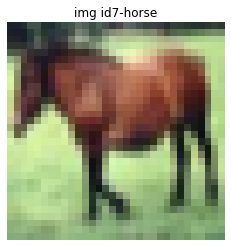

In [4]:
img_index = 0
plt.title('img id'+str(img_ids[img_index])+'-'+ \
    labels_map[int(labels[img_index].numpy())])
plt.axis("off")
plt.imshow(np.transpose(imgs[0].numpy(), (1,2,0)))

In [5]:
x = imgs.to(device)
# tensor(long) -> one_hot
y = label_to_onehot(labels).to(device)
print('imgs shape is', x.shape)
print('labels shape is', y.shape)

imgs shape is torch.Size([1, 3, 32, 32])
labels shape is torch.Size([1, 10])


### 1.2 gradient leakage attack (DLG, NeurIPS19, MIT)

In [6]:
# Compute prediction and loss
model = net().to(device)
pred = model(x)
print('logits shape is', pred.shape)
loss_fn = cross_entropy_for_onehot
loss = loss_fn(pred, y)

logits shape is torch.Size([1, 10])


In [7]:
# Compute original gradients
dy_dx = torch.autograd.grad(outputs=loss, 
                            inputs=model.parameters())
original_dy_dx = list((_.detach().clone() for _ in dy_dx))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


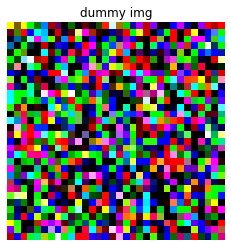

In [8]:
# Generate dummy data and label
dummy_data = torch.randn(x.shape)
dummy_label = torch.randn(y.shape)
plt.title('dummy img')
plt.axis("off")
plt.imshow(np.transpose(dummy_data[0].numpy(), (1,2,0)))

In [9]:
dummy_data = dummy_data.to(device).requires_grad_(True)
dummy_label = dummy_label.to(device).requires_grad_(True)

In [10]:
# Reconstruction in DLG
optimizer = torch.optim.LBFGS([dummy_data, dummy_label])
for iters in range(iteration_steps):
    def closure():
        optimizer.zero_grad()
        dummy_pred = model(dummy_data) 
        # Regularization
        dummy_label_ = F.softmax(dummy_label, dim=-1)
        dummy_loss = loss_fn(dummy_pred, dummy_label_) 
        # Create_graph for LBFGS
        dummy_dy_dx = torch.autograd.grad(outputs=dummy_loss, 
                                          inputs=model.parameters(), 
                                          create_graph=True)
        
        grad_diff = 0
        for gx, gy in zip(dummy_dy_dx, original_dy_dx): 
            grad_diff += ((gx - gy) ** 2).sum()
        grad_diff.backward()            
        return grad_diff
        
    optimizer.step(closure)
    if iters % 10 == 0: 
        current_loss = closure()
        print(iters, "%.4f" % current_loss.item())

0 0.0063
10 0.0000
20 0.0000
30 0.0000
40 0.0000
50 0.0000
60 0.0000
70 0.0000
80 0.0000
90 0.0000
100 0.0000
110 0.0000
120 0.0000
130 0.0000
140 0.0000
150 0.0000
160 0.0000
170 0.0000
180 0.0000
190 0.0000
200 0.0000
210 0.0000
220 0.0000
230 0.0000
240 0.0000
250 0.0000
260 0.0000
270 0.0000
280 0.0000
290 0.0000


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


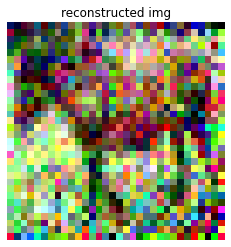

In [11]:
plt.title('reconstructed img')
plt.axis("off")
plt.imshow(np.transpose(dummy_data[0].detach().cpu().numpy(), (1,2,0)))

### 1.3 gradient perturbation

#### 1.3.1 rootset based gradient sensitivity (leakage risk) evaluation 

Rootset size is 50


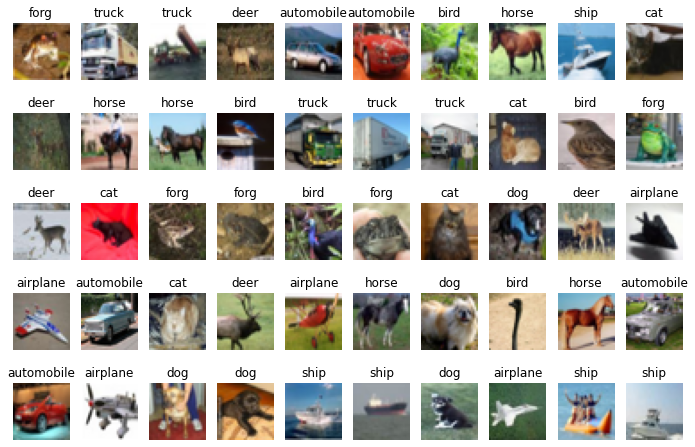

In [15]:
print(f"Rootset size is {len(data_loader.root_set)}")
figure = plt.figure(figsize=(12, 8))
cols, rows = 10, 5
for i in range(1, cols * rows+1):
    img, label = data_loader.root_set[i-1]
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis("off")
    plt.imshow(np.transpose(img.numpy(), (1,2,0)))
plt.show() 

In [16]:
for name, parameters in model.named_parameters():
    print(name, ':', parameters.size())

body.0.weight : torch.Size([12, 3, 5, 5])
body.0.bias : torch.Size([12])
body.2.weight : torch.Size([12, 12, 5, 5])
body.2.bias : torch.Size([12])
body.4.weight : torch.Size([12, 12, 5, 5])
body.4.bias : torch.Size([12])
fc.0.weight : torch.Size([10, 768])
fc.0.bias : torch.Size([10])


In [17]:
from sensitivity import compute_sens
sensitivity = compute_sens(model = model,
                           rootset_loader = data_loader.root_set_loader,
                           device = device)

#### 1.3.2 gradient sensitivity based slicing and random perturbation

In [18]:
from perturb import noise
# Slicing gradients and random perturbing 
perturbed_dy_dx = noise(dy_dx = dy_dx, 
                        sensitivity = sensitivity,
                        slices_num = slices_num,
                        perturb_slices_num = perturb_slices_num,
                        scale = scale)
for layer in perturbed_dy_dx:
    print(layer.shape)

torch.Size([12, 3, 5, 5])
torch.Size([12])
torch.Size([12, 12, 5, 5])
torch.Size([12])
torch.Size([12, 12, 5, 5])
torch.Size([12])
torch.Size([10, 768])
torch.Size([10])


#### 1.3.3 random perturbation + DLG

0 0.0104
10 0.0025
20 0.0025
30 0.0025
40 0.0025
50 0.0025
60 0.0025
70 0.0025
80 0.0025
90 0.0025
100 0.0025
110 0.0025
120 0.0025
130 0.0025
140 0.0025
150 0.0025
160 0.0025
170 0.0025
180 0.0025
190 0.0025
200 0.0025
210 0.0025
220 0.0025
230 0.0025
240 0.0025
250 0.0025
260 0.0025
270 0.0025
280 0.0025
290 0.0025


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


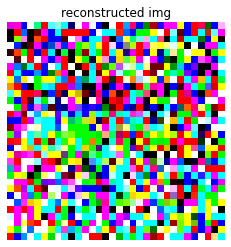

In [20]:
original_dy_dx = []
for layer in perturbed_dy_dx:
    layer = layer.to(device)
    original_dy_dx.append(layer)

# Generate dummy data and label
dummy_data = torch.randn(x.shape)
dummy_label = torch.randn(y.shape)
dummy_data = dummy_data.to(device).requires_grad_(True)
dummy_label = dummy_label.to(device).requires_grad_(True)

# Reconstruction in DLG
optimizer = torch.optim.LBFGS([dummy_data, dummy_label])
for iters in range(iteration_steps):
    def closure():
        optimizer.zero_grad()
        dummy_pred = model(dummy_data) 
        # Regularization
        dummy_label_ = F.softmax(dummy_label, dim=-1)
        dummy_loss = loss_fn(dummy_pred, dummy_label_) 
        # Create_graph for LBFGS
        dummy_dy_dx = torch.autograd.grad(outputs=dummy_loss, 
                                          inputs=model.parameters(), 
                                          create_graph=True)
        
        grad_diff = 0
        for gx, gy in zip(dummy_dy_dx, original_dy_dx): 
            grad_diff += ((gx - gy) ** 2).sum()
        grad_diff.backward()            
        return grad_diff
        
    optimizer.step(closure)
    if iters % 10 == 0: 
        current_loss = closure()
        print(iters, "%.4f" % current_loss.item())
        
plt.title('reconstructed img')
plt.axis("off")
plt.imshow(np.transpose(dummy_data[0].detach().cpu().numpy(), (1,2,0)))

## Part. 2 Aggregation and Compensation

### 2.1 load settings

In [21]:
aggregation_base = 10 # Num of aggregated batches
aggregation_weight = []
for i in range(aggregation_base):
    aggregation_weight.append(1.0 / aggregation_base)
Q = 6

In [23]:
from train import train_one_batch
# Load batch data and compute their perturbed gradients 
gradients_pool = []
perturbed_gradients_pool = []
    
for grad_id in range(aggregation_base):
    # Compute gradients 
    dy_dx = train_one_batch(model = model,
                            train_loader = data_loader.train_set_loader, 
                            device = device)
        
    gradients_pool.append(dy_dx)
        
    # Slicing gradients and random perturbing 
    perturbed_dy_dx = noise(dy_dx = dy_dx, 
                            sensitivity = sensitivity,
                            slices_num = slices_num,
                            perturb_slices_num = perturb_slices_num,
                                scale = scale)
        
    perturbed_grads = []
    for layer in perturbed_dy_dx:
        layer = layer.to(device)
        perturbed_grads.append(layer)
        
    perturbed_gradients_pool.append(perturbed_grads)

In [24]:
# Aggregate the gradients by their weights
layers_num = len(gradients_pool[0])
layer_dims_pool = []
for layer_gradient in gradients_pool[0]:    
    layer_dims = list((_ for _ in layer_gradient.shape))
    layer_dims_pool.append(layer_dims)

_gradients = []
_gradients_perturbed = []
for layer_index in range(layers_num):
    # Aggregate clean gradients
    gradients__ = torch.zeros(layer_dims_pool[layer_index]).to(device)
    for gradients_index in range(len(gradients_pool)):
        gradients__ += gradients_pool[gradients_index][layer_index] \
            * aggregation_weight[gradients_index]
    _gradients.append(gradients__)
    # Aggregate perturbed gradients
    perturbed_gradients__ = torch.zeros(layer_dims_pool[layer_index]).to(device)
    for gradients_index in range(len(perturbed_gradients_pool)):
        perturbed_gradients__ += perturbed_gradients_pool[gradients_index][layer_index] \
            * aggregation_weight[gradients_index]
    _gradients_perturbed.append(perturbed_gradients__)

### 2.2 compensate by denoising 

In [26]:
import math
from compensate import denoise 
# Compensate by denoising
_scale = 0
for grad_id in range(aggregation_base):
    _scale += aggregation_base * perturb_slices_num / slices_num \
        * (scale ** 2) * aggregation_weight[grad_id]

# Compensate gradients
gradients_compensated = denoise(gradients = _gradients_perturbed,
                                scale = math.sqrt(_scale),
                                Q = Q)

In [27]:
for layer in range(len(gradients_compensated)):
    if layer <= 2: # Show diff F-norm 
        print(gradients_compensated[layer].shape)
        layer_compensated = gradients_compensated[layer].to(device)
        # Show diff F-norm between compensated and clean aggregated gradients 
        print(torch.norm(layer_compensated - _gradients[layer]))
        # Show diff F-norm between perturbed and clean aggregated gradients
        print(torch.norm(_gradients_perturbed[layer] - _gradients[layer]))

torch.Size([12, 3, 5, 5])
tensor(0.0033, device='cuda:0', dtype=torch.float64)
tensor(0.0038, device='cuda:0')
torch.Size([12])
tensor(0.0004, device='cuda:0', dtype=torch.float64)
tensor(0.0005, device='cuda:0')
torch.Size([12, 12, 5, 5])
tensor(0.0064, device='cuda:0', dtype=torch.float64)
tensor(0.0068, device='cuda:0')


## Part. 3 Sample-wise Gradient Clipping [Optional]

In [28]:
from train import train_by_gradient_clipping
# Compute gradients by sample-wise
dy_dx = train_by_gradient_clipping(model = model,
                                   train_loader = data_loader.train_set_loader, 
                                   device = device)

In [29]:
from clip import noise
# Slicing gradients and random perturbing with clipping
perturbed_dy_dx = noise(dy_dx = dy_dx, 
                        sensitivity = sensitivity,
                        slices_num = slices_num,
                        perturb_slices_num = perturb_slices_num,
                        noise_intensity = scale)
for layer in perturbed_dy_dx:
    print(layer.shape)

torch.Size([12, 3, 5, 5])
torch.Size([12])
torch.Size([12, 12, 5, 5])
torch.Size([12])
torch.Size([12, 12, 5, 5])
torch.Size([12])
torch.Size([10, 768])
torch.Size([10])
